In [15]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from PIL import Image
import os
from scipy.spatial.distance import cdist
import scipy
import pandas as pd
import pickle

In [16]:
vgg_model = VGG16(weights='imagenet', include_top=False)
input_dir = "pokemon_card_images"  # Directory containing original images
output_dir = "cropped_images"      # Directory to store cropped images

In [17]:
def preprocess_image(image_path):
    img = Image.open(image_path).convert('RGB')  # Open the image and ensure it's in RGB mode
    img = img.resize((224, 224))  # Resize the image to 224x224 (VGG16 input size)
    
    # Convert the image to an array and expand the dimensions (to match batch size of 1)
    img_array = np.array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add a batch dimension
    
    # Preprocess the image for VGG16
    return preprocess_input(img_array)

In [18]:
def extract_features(image_path):
    preprocessed_img = preprocess_image(image_path)
    
    # Extract features using VGG16
    features = vgg_model.predict(preprocessed_img)
    
    # Flatten the output to a 1D array (if needed)
    features = features.flatten()
    
    return features


In [ ]:
os.system('rm -rf cropped_images/')
os.makedirs(output_dir, exist_ok=True)


with open('pokemon_list.pkl', 'rb') as f:
    pokemon_list = pickle.load(f)

import re
delimiters ='-bs', '-ju-', '-fo-', '-tr', '-black', '-heroes','-challenge', '.jpg'
regex_pattern = '|'.join(map(re.escape, delimiters))
cards_list = []

# Define the cropping box (left, upper, right, lower)
crop_box = (90, 65, 400, 320)  # Example: Cropping a rectangle from (100, 100) to (400, 500)

# List to store features of all images
features_list = []

# Loop through the images in the input directory
for filename in os.listdir(input_dir):
    card_name = re.split(regex_pattern, filename)[0]
    if card_name in cards_list:
        continue # no non-holo repeats this is failing with the neo sets now because neo not a delimeter but they have diff variations so ill allow for now
    elif not any(pokemon in card_name for pokemon in pokemon_list):
        continue # non-pokemon cards some slip thru cracks like clefairy doll
    elif 'base-set-2' in filename or 'legendary-collection' in filename:
        continue #no bs2 and no lc
    else:
        cards_list.append(card_name)
    if filename.endswith(".jpg") or filename.endswith(".jpeg"):  # Check for image formats
        image_path = os.path.join(input_dir, filename)
    
        
        try:
            # Open the image
            img = Image.open(image_path)
            
            # Crop the image
            cropped_img = img.crop(crop_box)
            
            # Save the cropped image
            cropped_path = os.path.join(output_dir, filename)
            cropped_img.save(cropped_path)  # Save the cropped image

            print(f"Cropped image saved: {filename}")
        
        except Exception as e:
            print(f"Error processing {filename}: {e}")
            continue  # Skip the current image and move to the next one

        # Extract features from the cropped image (use actual image data here)
        print(f"Extracting features from {filename}...")
        features = extract_features(cropped_path)  # Pass the cropped image itself
        features_list.append(features)



with open('cards_list.pkl', 'wb') as f:
    pickle.dump(cards_list, f)

# Optionally, save the features to a CSV file
df = pd.DataFrame(features_list)
df.to_csv("vgg_features.csv", index=False)
print("Feature extraction completed and saved to vgg_features.csv.")

Cropped image saved: abra-base-set-bs-43.jpg
Extracting features from abra-base-set-bs-43.jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
Cropped image saved: abra-team-rocket-tr-49.jpg
Extracting features from abra-team-rocket-tr-49.jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
Cropped image saved: aerodactyl-fossil-fo-1.jpg
Extracting features from aerodactyl-fossil-fo-1.jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
Cropped image saved: aerodactyl-neo-revelation-15.jpg
Extracting features from aerodactyl-neo-revelation-15.jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
Cropped image saved: aipom-neo-genesis-26.jpg
Extracting features from aipom-neo-genesis-26.jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
Cropped image saved: aipom-neo-revelation-41.jpg
Extracting features from aipom-neo-revelation-41.jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
Cropped image saved: alakazam-base-set-bs-1.jpg
Extracting features from alakazam-base-set-bs-1.jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
Cr

In [20]:
features_csv = "vgg_features.csv"
features_list = pd.read_csv(features_csv)

with open('cards_list.pkl', 'rb') as f:
    cards_list = pickle.load(f)

# Assuming you have your extracted features stored in 'features_list' 
# as a NumPy array, one feature vector per image
features_array = np.array(features_list)

# Calculate the pairwise cosine similarity between all feature vectors
similarity_matrix = cosine_similarity(features_array)

# Print the similarity matrix (optional, as it can be large)
print("Cosine Similarity Matrix:")
print(similarity_matrix)

Cosine Similarity Matrix:
[[1.         0.24860368 0.23819066 ... 0.24580274 0.29149629 0.25689325]
 [0.24860368 1.         0.20930501 ... 0.3026522  0.27759483 0.29010041]
 [0.23819066 0.20930501 1.         ... 0.22791028 0.23096354 0.26359935]
 ...
 [0.24580274 0.3026522  0.22791028 ... 1.         0.34601832 0.30247053]
 [0.29149629 0.27759483 0.23096354 ... 0.34601832 1.         0.36516628]
 [0.25689325 0.29010041 0.26359935 ... 0.30247053 0.36516628 1.        ]]


In [21]:
# For Cosine Similarity
# Find the index of the maximum similarity (ignoring self-comparison)

np.fill_diagonal(similarity_matrix, 0)  # Set diagonal to 0 so it doesn't consider the image itself
most_similar_idx = np.unravel_index(np.argmax(similarity_matrix, axis=None), similarity_matrix.shape)
print(f"Most similar images are {cards_list[most_similar_idx[0]]} and {cards_list[most_similar_idx[1]]} with similarity {similarity_matrix[most_similar_idx]}")

Most similar images are forretress-neo-discovery-2 and forretress-neo-discovery-21 with similarity 0.8245082554345832


In [22]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Assuming you have your extracted features stored in 'features_list' 
# as a NumPy array, one feature vector per image
features_array = np.array(features_list)

# Calculate the pairwise cosine similarity between all feature vectors
similarity_matrix = cosine_similarity(features_array)

np.fill_diagonal(similarity_matrix, np.nan)  # Ignore self-similarity by setting diagonal to NaN
min_similarity = np.nanmin(similarity_matrix)  # Find the smallest similarity score
most_different_pair = np.unravel_index(np.nanargmin(similarity_matrix), similarity_matrix.shape)

# Step 3: Retrieve the names of the most different images
image_a = cards_list[most_different_pair[0]]
image_b = cards_list[most_different_pair[1]]

# Print the results
print(f"The most different images are:")
print(f"{image_a} and {image_b} with similarity score: {min_similarity:.4f}")

The most different images are:
dark-ursaring-neo-destiny-21 and unown-t-neo-destiny-88 with similarity score: 0.0812


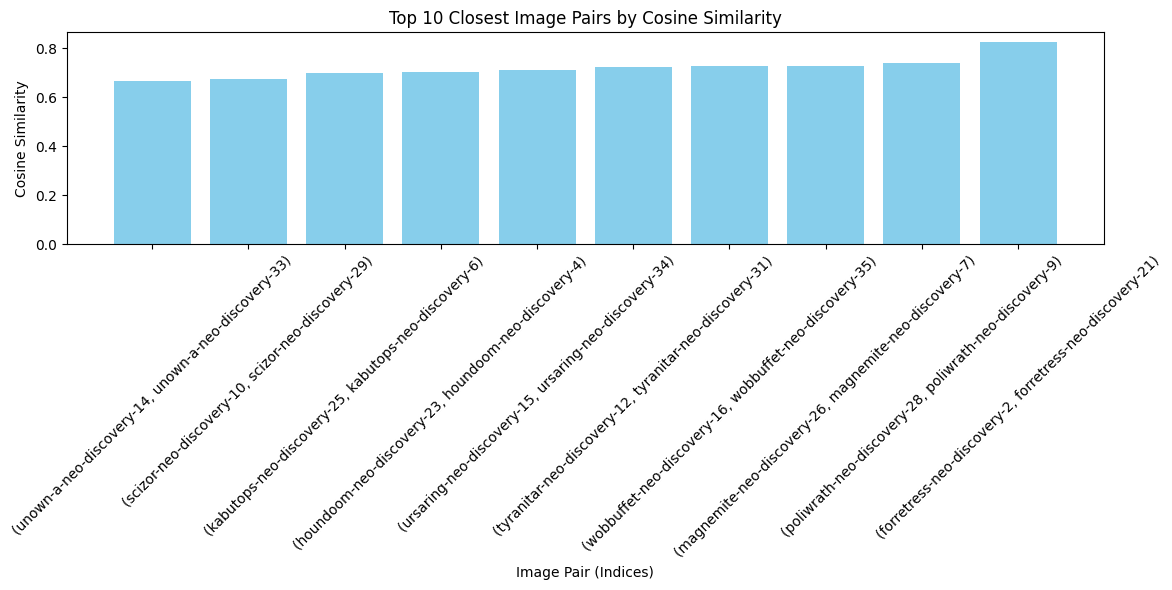

In [26]:
import matplotlib.pyplot as plt
tri_upper_indices = np.triu_indices(len(similarity_matrix), k=1)
cos_sim_values = similarity_matrix[tri_upper_indices]

# Get the indices of the 10 highest cosine similarities
top_10_indices = np.argsort(cos_sim_values)[-10:]

top_pairs = [(tri_upper_indices[0][idx], tri_upper_indices[1][idx]) for idx in top_10_indices]
top_sim_values = cos_sim_values[top_10_indices]

x_labels = [f"({cards_list[pair[0]]}, {cards_list[pair[1]]})" for pair in top_pairs]
#x_labels = [f"({pair[0]}, {pair[1]})" for pair in top_pairs]

# Step 5: Plot the cosine similarity values
fig, ax = plt.subplots(figsize=(12, 6))

# Create the bar plot for the top 10 cosine similarity values
ax.bar(range(10), top_sim_values, tick_label=x_labels, color='skyblue')

# Add labels and title
ax.set_xlabel('Image Pair (Indices)')
ax.set_ylabel('Cosine Similarity')
ax.set_title('Top 10 Closest Image Pairs by Cosine Similarity')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

IndexError: index 2 is out of bounds for axis 0 with size 2

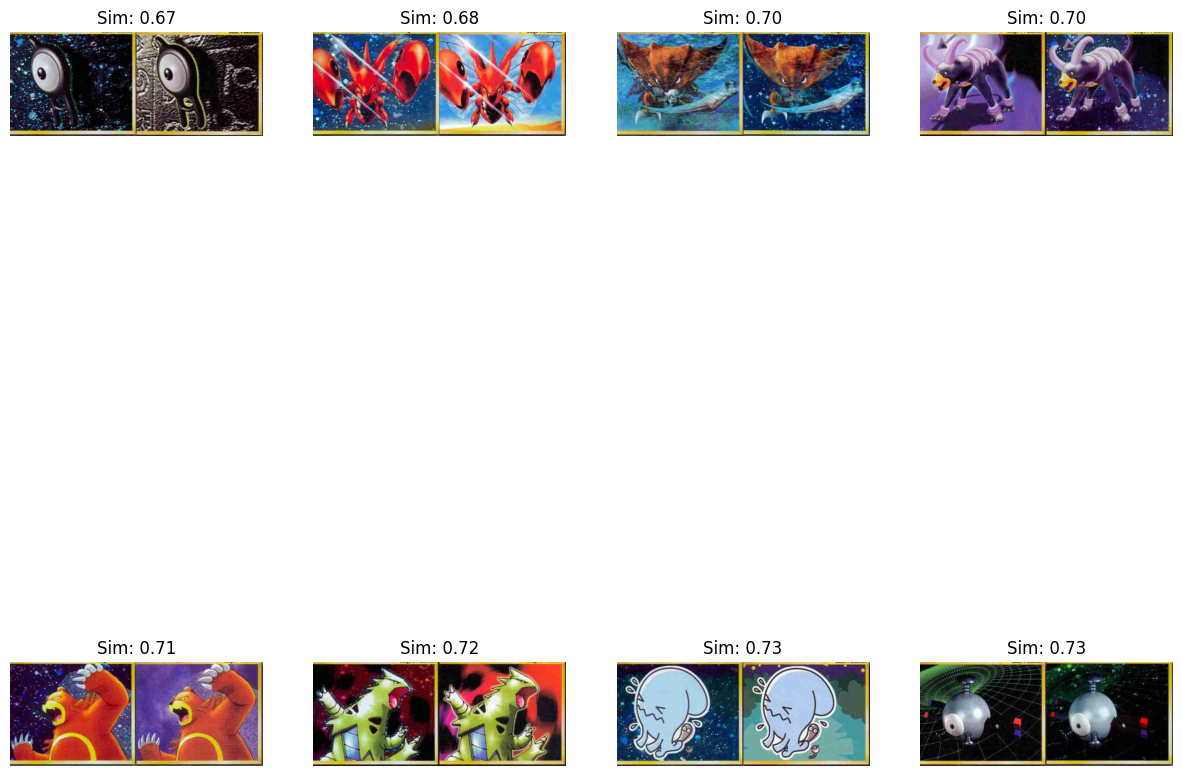

In [27]:
# Step 3: Plot the 10 closest pairs
fig, axes = plt.subplots(2, 4, figsize=(15, 15))

for i, idx in enumerate(top_10_indices):
    # Get the pair of indices for the closest pair
    pair_idx = (tri_upper_indices[0][idx], tri_upper_indices[1][idx])
    
    # Load the images for the pair
    find_img_1 = [f for f in os.listdir(output_dir) if cards_list[pair_idx[0]] in f and f.endswith('.jpg')][0]
    find_img_2 = [f for f in os.listdir(output_dir) if cards_list[pair_idx[1]] in f and f.endswith('.jpg')][0]
    img1 = Image.open(os.path.join(output_dir, find_img_1))
    img2 = Image.open(os.path.join(output_dir, find_img_2))

    # Plot the images in a grid
    ax = axes[i // 4, i % 4]
    ax.imshow(np.hstack([np.array(img1), np.array(img2)]))  # Display pair side by side
    ax.axis('off')
    ax.set_title(f"Sim: {cos_sim_values[idx]:.2f}")

plt.tight_layout()
plt.show()

In [28]:
import networkx as nx
import plotly.graph_objects as go
import numpy as np
import os
import base64
from PIL import Image
from io import BytesIO

# Path to your image directory
image_directory = "cropped_images"

# Get all image file paths from the directory
image_files = [os.path.join(image_directory, img) for img in os.listdir(image_directory) if img.endswith(('.png', '.jpg', '.jpeg'))]

# Ensure the number of images matches the number of nodes
num_nodes = len(image_files)

threshold = 0.42

# Assuming you already have a similarity matrix
# similarity_matrix = ...  # Your actual similarity matrix here

# Create graph
G = nx.Graph()
for i in range(len(similarity_matrix)):
    for j in range(i + 1, len(similarity_matrix)):
        if similarity_matrix[i, j] > threshold:
            G.add_edge(i, j, weight=similarity_matrix[i, j])

# Get positions using spring layout
pos = nx.spring_layout(G)

# Encode images in Base64
def encode_image(image_path):
    """Encode image as Base64 string."""
    with open(image_path, "rb") as img_file:
        encoded = base64.b64encode(img_file.read()).decode('ascii')
    return f"data:image/png;base64,{encoded}"

# Map images to nodes
node_images = [encode_image(img) for img in image_files]

# Create edge traces (no width based on similarity)
edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),  # Default edge width
    hoverinfo='none',
    mode='lines'
)

# Create the figure
fig = go.Figure()

# Add edges
fig.add_trace(edge_trace)

# Add images as node markers (translucent images)
for node in G.nodes():
    x, y = pos[node]
    fig.add_layout_image(
        dict(
            source=node_images[node],  # Use node to access the image from the list
            x=x,
            y=y,
            xref="x",
            yref="y",
            sizex=0.1,  # Initial size of the image
            sizey=0.1,
            xanchor="center",
            yanchor="middle",
            layer="above",
            opacity=0.6  # Set opacity for translucency (0 is fully transparent, 1 is fully opaque)
        )
    )

# Set layout
fig.update_layout(
    title='Network Diagram with Images as Nodes',
    titlefont_size=16,
    showlegend=False,
    hovermode='closest',
    margin=dict(b=0, l=0, r=0, t=40),
    xaxis=dict(showgrid=False, zeroline=False),
    yaxis=dict(showgrid=False, zeroline=False),
)

fig.show()
